In [54]:
# !pip install seaborn
# !pip install keras
# !pip install tensorflow
# !pip install xgboost


In [55]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta
from ta.volatility import AverageTrueRange
# import pandas_ta as ta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
import requests
import json
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Permute, Reshape, Multiply, Flatten, Input
from tensorflow.keras.layers import AdditiveAttention # Make sure this is correctly imported
from tensorflow.keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from pmdarima import auto_arima


In [56]:
# with open("tingo_api.json", "r") as file:
#     tingo_api = json.load(file)
# api_key = tingo_api['api_key']

In [57]:
# headers = {
#     'Content-Type': 'application/json',
#     'Authorization': f'Token {api_key}'
# }
# url =  "https://api.tiingo.com/tiingo/daily/MSFT/prices?startDate=2017-06-13&endDate=2025-06-13&resampleFreq=1min"


# response = requests.get(url, headers=headers)
# data = response.json()

# ARIMA

In [58]:
msft = yf.Ticker("AAPL")
msft_df = msft.history(
    period="max",
    interval="1h", 
)
print(msft_df.head())
msft_df.shape

                                 Open        High         Low       Close  \
Datetime                                                                    
2023-07-11 09:30:00-04:00  189.160004  189.300003  187.449997  188.110001   
2023-07-11 10:30:00-04:00  188.095001  188.560104  187.654999  187.714996   
2023-07-11 11:30:00-04:00  187.715698  188.380005  187.259995  187.615005   
2023-07-11 12:30:00-04:00  187.619995  187.786896  187.339996  187.410004   
2023-07-11 13:30:00-04:00  187.406006  187.547806  186.700104  186.880997   

                             Volume  Dividends  Stock Splits  
Datetime                                                      
2023-07-11 09:30:00-04:00  10238697        0.0           0.0  
2023-07-11 10:30:00-04:00   4788400        0.0           0.0  
2023-07-11 11:30:00-04:00   5419136        0.0           0.0  
2023-07-11 12:30:00-04:00   3590478        0.0           0.0  
2023-07-11 13:30:00-04:00   5978219        0.0           0.0  


(3487, 7)

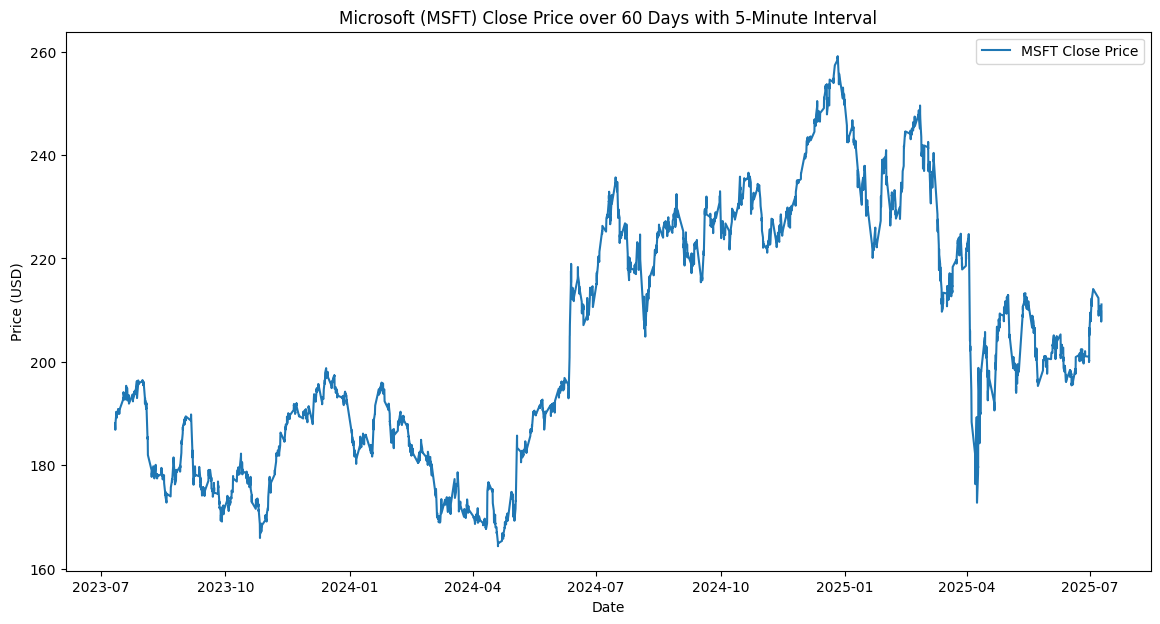

In [59]:
plt.figure(figsize=(14, 7))
plt.plot(msft_df.index, msft_df['Close'], label='MSFT Close Price')
plt.title('Microsoft (MSFT) Close Price over 60 Days with 5-Minute Interval')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend();

# Preprocessing

## Handling NaNs

In [60]:
msft_df.isnull().sum().sum()

0

## Handling Outliers

In [61]:
Q1 = msft_df.quantile(0.25)
Q3 = msft_df.quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = msft_df[~((msft_df < (Q1 - 3 * IQR)) | (msft_df > (Q3 + 3 * IQR))).any(axis=1)]
print(f"The Amount of Outliers Removed: {msft_df.shape[0] - df_no_outliers.shape[0]}")

The Amount of Outliers Removed: 99


## Handling Duplicates

In [62]:
msft_df[msft_df.duplicated()]
msft_df.duplicated().sum()

0

## Feature Engineering

### Lagged Prices

In [63]:
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    lag_periods = [1, 2, 3, 4, 5, 6] # within 1 day range
    for lag in lag_periods:
        msft_df[f'{col}_price_lag_{lag}H'] = msft_df[col].shift(lag)

### Lagged Returns

#### Hourly

In [64]:
msft_df['Hourly_return'] = msft_df['Close'].pct_change(periods=1)
lag_returns_hourly = [1, 2, 3, 4, 5, 6] # range within 1 day
for lag in lag_returns_hourly:
    msft_df[f'Hourly_return_lag_{lag}H'] = msft_df['Hourly_return'].shift(lag)

#### Daily

In [65]:
msft_df['Daily_return'] = msft_df['Close'].pct_change(periods=7)
lag_returns_daily = [7,14,21,28] # 1-4 day range
for lag in lag_returns_daily:
    msft_df[f'Daily_return_lag_{lag}H'] = msft_df['Daily_return'].shift(lag)

#### Weekly

In [66]:
msft_df['Weekly_return'] = msft_df['Close'].pct_change(periods=35)
lag_returns_weekly = [35] # range within 2 weeks
for lag in lag_returns_weekly:
    msft_df[f'weekly_return_lag_{lag}H'] = msft_df['Weekly_return'].shift(lag)

### Moving Averages

#### Simple

In [67]:
sma_windows = [5, 7, 10, 21, 28, 35]
for window in sma_windows:
    msft_df[f'SMA_{window}H'] = msft_df['Close'].rolling(window=window).mean()

#### Exponential

In [68]:
ema_windows = [5, 7, 10, 21, 28, 35]
for window in ema_windows:
    msft_df[f'EMA_{window}H'] = msft_df['Close'].ewm(span=window, adjust=False).mean()

#### Logarithmic Simple

I created these wild fixing the stationarity

In [69]:
msft_df['Log_Close'] = np.log(msft_df['Close'])
msft_df['Rolling_Log_Avg'] = msft_df['Log_Close'].rolling(7).mean()
msft_df['Rolling_Log_Std'] = msft_df['Log_Close'].rolling(7).std()

### Volatility

#### Standard Deviation

In [70]:
volatility_window = [3, 7, 14, 21, 28, 35]

for window in volatility_window:
    msft_df[f'Volatility_StdDEV_{window}H'] = msft_df['Hourly_return'].rolling(window=window).std()

### Technical Indicators

#### Average True Range (Volatility)

In [71]:
atr_periods = [7, 14, 21, 28, 35]

for period in atr_periods:
    atr = AverageTrueRange(
        high=msft_df['High'],
        low=msft_df['Low'],
        close=msft_df['Close'].shift(1),
        window=period,
        fillna=False
    )
    msft_df[f'ATR_{period}H'] = atr.average_true_range()

#### RSI (Momentum Indicator)

In [72]:
from ta.momentum import RSIIndicator

rsi_indicator = RSIIndicator(close=msft_df['Close'], window=14)


msft_df['RSI_14'] = rsi_indicator.rsi()

msft_df['RSI_Overbought'] = (msft_df['RSI_14'] > 70).astype(int)
msft_df['RSI_Oversold'] = (msft_df['RSI_14'] < 30).astype(int)

#### MACD (Momentum Indicator)

In [73]:
from ta.trend import MACD

macd_indicator = MACD(
    close=msft_df['Close'],
    window_slow=26,
    window_fast=12,
    window_sign=9,
    fillna=False
)

msft_df['MACD'] = macd_indicator.macd()
msft_df['MACD_Signal'] = macd_indicator.macd_signal()
msft_df['MACD_Histogram'] = macd_indicator.macd_diff()

msft_df['MACD_Prev'] = msft_df['MACD'].shift(1)
msft_df['MACD_Signal_Prev'] = msft_df['MACD_Signal'].shift(1)
msft_df['MACD_Cross_Up'] = ((msft_df['MACD'] > msft_df['MACD_Signal']) & (msft_df['MACD_Prev'] <= msft_df['MACD_Signal_Prev'])).astype(int)
msft_df['MACD_Cross_Down'] = ((msft_df['MACD'] < msft_df['MACD_Signal']) & (msft_df['MACD_Prev'] >= msft_df['MACD_Signal_Prev'])).astype(int)

#### Bollinger Bands (Volatility Indicator)

In [74]:
from ta.volatility import BollingerBands


bb_indicator = BollingerBands(
    close=msft_df['Close'],
    window=2,         
    window_dev=2,     
    fillna=False
)

msft_df['Bollinger_Lower'] = bb_indicator.bollinger_lband()
msft_df['Bollinger_Middle'] = bb_indicator.bollinger_mavg()
msft_df['Bollinger_Upper'] = bb_indicator.bollinger_hband()
msft_df['Bollinger_Bandwidth_Raw'] = bb_indicator.bollinger_wband()
msft_df['Bollinger_PercentageB'] = bb_indicator.bollinger_pband()

msft_df['Bollinger_Bandwidth'] = msft_df['Bollinger_Bandwidth_Raw'] / 100
msft_df['Price_Above_Upper_BB'] = (msft_df['Close'] > msft_df['Bollinger_Upper']).astype(int)
msft_df['Price_Below_Lower_BB'] = (msft_df['Close'] < msft_df['Bollinger_Lower']).astype(int)

#### Stochastic Oscillator (Momentum Indicator)

In [75]:
from ta.momentum import StochasticOscillator

# Create the Stochastic Oscillator object
stoch = StochasticOscillator(
    high=msft_df['High'],
    low=msft_df['Low'],
    close=msft_df['Close'],
    window=14,      
    smooth_window=3, 
    fillna=False
)

msft_df['%K'] = stoch.stoch()

msft_df['%D'] = stoch.stoch_signal()

#### ADX (Trend/Momentum Indicator)

In [76]:
from ta.trend import ADXIndicator


adx = ADXIndicator(
    high=msft_df['High'],
    low=msft_df['Low'],
    close=msft_df['Close'],
    window=14,
    fillna=False
)


msft_df['ADX_14'] = adx.adx()
msft_df['Positive_DI'] = adx.adx_pos()
msft_df['Negative_DI'] = adx.adx_neg()


msft_df['Trend_Strong_ADX'] = (msft_df['ADX_14'] > 25).astype(int)


### Time Stamps

In [77]:
msft_df['Hour'] = msft_df.index.hour
msft_df['Day_of_Week'] = msft_df.index.dayofweek
msft_df['Day_of_Month'] = msft_df.index.day
msft_df['Month'] = msft_df.index.month
msft_df['Year'] = msft_df.index.year
msft_df['Week_of_Year'] = msft_df.index.isocalendar().week.astype(int)

C:\Users\billy\AppData\Local\Temp\ipykernel_30332\2403176649.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Hour'] = msft_df.index.hour
C:\Users\billy\AppData\Local\Temp\ipykernel_30332\2403176649.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Day_of_Week'] = msft_df.index.dayofweek
C:\Users\billy\AppData\Local\Temp\ipykernel_30332\2403176649.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

In [78]:
msft_df['Hour_sin'] = np.sin(2 * np.pi * msft_df['Hour'] / 24)
msft_df['Hour_cos'] = np.cos(2 * np.pi * msft_df['Hour'] / 24)
msft_df['Day_of_Week_sin'] = np.sin(2 * np.pi * msft_df['Day_of_Week'] / 7)
msft_df['Day_of_Week_cos'] = np.cos(2 * np.pi * msft_df['Day_of_Week'] / 7)
msft_df = pd.get_dummies(msft_df, columns=['Day_of_Week'], prefix='Day', drop_first=False)
msft_df = pd.get_dummies(msft_df, columns=['Month'], prefix='Month', drop_first=False)

C:\Users\billy\AppData\Local\Temp\ipykernel_30332\2951078873.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Hour_sin'] = np.sin(2 * np.pi * msft_df['Hour'] / 24)
C:\Users\billy\AppData\Local\Temp\ipykernel_30332\2951078873.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Hour_cos'] = np.cos(2 * np.pi * msft_df['Hour'] / 24)
C:\Users\billy\AppData\Local\Temp\ipykernel_30332\2951078873.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

### Volume Based

#### Moving Average

In [79]:
for window in [7, 14, 21, 28, 35]:
    msft_df[f'Volume_SMA_{window}H'] = msft_df['Volume'].rolling(window=window).mean()
msft_df['Volume_Change'] = msft_df['Volume'].pct_change()

#### On-Balanced Volume (Momentum Indicator)

In [80]:
from ta.volume import OnBalanceVolumeIndicator

# Create the OBV indicator object
obv_indicator = OnBalanceVolumeIndicator(
    close=msft_df['Close'],
    volume=msft_df['Volume'],
    fillna=False
)

# Calculate OBV and its 9-period EMA
msft_df['OBV'] = obv_indicator.on_balance_volume()
msft_df['OBV_EMA_9H'] = msft_df['OBV'].ewm(span=9, adjust=False).mean()

### Price Action Patterns

In [81]:
msft_df['High_Low_Range'] = msft_df['High'] - msft_df['Low']
msft_df['Open_Close_Range'] = msft_df['Close'] - msft_df['Open']
msft_df['High_Low_Range_Pct'] = (msft_df['High'] - msft_df['Low']) / msft_df['Close'] * 100
msft_df['Open_Close_Range_Pct'] = (msft_df['Close'] -  msft_df['Open']) / msft_df['Open'] * 100

### Other

In [82]:
msft_df['RSI_x_Volume'] = msft_df['RSI_14'] * msft_df['Volume']

### Imputation

In [83]:
print("amount of nans before accounting for largest window size:", msft_df.isna().sum().sum())

amount of nans before accounting for largest window size: 883


In [84]:
msft_df = msft_df.iloc[35:]
print("amount of nans after accounting for largest window size:", msft_df.isna().sum().sum())

amount of nans after accounting for largest window size: 43


In [85]:
print(msft_df.dtypes[msft_df.isna().any()])

weekly_return_lag_35H    float64
Bollinger_PercentageB    float64
dtype: object


In [86]:
print(f"Bollinger_PercentageB NaN count:", msft_df['Bollinger_PercentageB'].isna().sum().sum())
# We can fill these NaNs with imputation function.

Bollinger_PercentageB NaN count: 8


In [87]:
print(f"weekly_return_lag_35H NaN count:", msft_df['weekly_return_lag_35H'].isna().sum())

weekly_return_lag_35H NaN count: 35


In [88]:
rows_to_drop = msft_df['weekly_return_lag_35H'].isna().sum()
total_columns = msft_df.shape[1]
datapoints_lost_rows = rows_to_drop * total_columns
print(f"Datapoints lost by dropping {rows_to_drop} rows: {datapoints_lost_rows:,}")

rows_total = msft_df.shape[0]
datapoints_lost_column = rows_total
print(f"Datapoints lost by dropping the column: {datapoints_lost_column:,}")
# Because of this point discrepancy we drop the column weekly_return_lag_35H

Datapoints lost by dropping 35 rows: 4,865
Datapoints lost by dropping the column: 3,452


In [89]:
msft_df.drop(columns=['weekly_return_lag_35H'], inplace=True)
print(f"Amount of NaNs after dropping the column:", msft_df.isna().sum().sum())

Amount of NaNs after dropping the column: 8


In [90]:
def impute_features(df):
    for col in df.columns:
        col_lower = col.lower()

        # columns that are not features
        if col_lower in ['Close']:
            continue

        # Rolling Averages, Price Lags, Return Lags, Volume-related, Log features
        if any(key in col_lower for key in ["price_lag", "hourly_return_lag", "daily_return_lag", 
                        "weekly_return_lag_", "sma", "ema", "volume", "rolling_log_avg", "rolling_log_std", "volatility"]):
            df[col] = df[col].ffill()

        # Technical Indicators
        elif any(key in col_lower for key in ["atr", "rsi", "macd", "bollinger", "upper_bb", "lower_bb", "adx", "di", "%d", "%k", "obv"]):
            df[col] = df[col].fillna(df[col].expanding().median())

        # Price Features
        elif any(key in col_lower for key in ["low_range", "close_range", "range_pct", "rsi_x_volume"]):
            df[col] = df[col].interpolate(method='linear')

        else:
            df[col] = df[col].interpolate(method='linear').ffill().bfill()

        
    return df

In [91]:
impute_features(msft_df)
print("amount of nans after accounting for imputing:", msft_df.isna().sum().sum())

amount of nans after accounting for imputing: 0


### Scaling

In [92]:
msft_df.replace([np.inf, -np.inf], np.nan, inplace=True)
impute_features(msft_df)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Open_price_lag_1H,Open_price_lag_2H,Open_price_lag_3H,...,Volume_SMA_28H,Volume_SMA_35H,Volume_Change,OBV,OBV_EMA_9H,High_Low_Range,Open_Close_Range,High_Low_Range_Pct,Open_Close_Range_Pct,RSI_x_Volume
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-18 09:30:00-04:00,193.350006,193.580002,192.794998,192.985001,9908873,0.0,0.0,194.139999,193.664993,193.080002,...,5.454860e+06,5.744171e+06,0.508263,43204585,4.566229e+07,0.785004,-0.365005,0.406769,-0.188780,6.347893e+08
2023-07-18 10:30:00-04:00,193.000000,193.654999,192.889999,193.145004,4922994,0.0,0.0,193.350006,194.139999,193.664993,...,5.357502e+06,5.748016e+06,-0.503173,48127579,4.615535e+07,0.764999,0.145004,0.396075,0.075132,3.202168e+08
2023-07-18 11:30:00-04:00,193.145004,193.259995,192.570007,192.705002,6601926,0.0,0.0,193.000000,193.350006,194.139999,...,5.381615e+06,5.781810e+06,0.341039,41525653,4.522941e+07,0.689987,-0.440002,0.358054,-0.227809,3.972613e+08
2023-07-18 12:30:00-04:00,192.699997,192.939896,192.414993,192.934998,4179318,0.0,0.0,193.145004,193.000000,193.350006,...,5.378795e+06,5.798634e+06,-0.366955,45704971,4.532452e+07,0.524902,0.235001,0.272062,0.121952,2.582180e+08
2023-07-18 13:30:00-04:00,192.940002,193.789993,192.899994,193.759995,3752506,0.0,0.0,192.699997,193.145004,193.000000,...,5.392558e+06,5.735042e+06,-0.102125,49457477,4.615111e+07,0.889999,0.819992,0.459331,0.424998,2.512290e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-09 11:30:00-04:00,207.809998,208.220001,207.265900,207.800003,4676493,0.0,0.0,209.889999,209.529999,209.589996,...,6.760025e+06,7.675477e+06,-0.437199,530669258,5.425850e+08,0.954102,-0.009995,0.459144,-0.004809,1.961543e+08
2025-07-09 12:30:00-04:00,207.810394,209.044998,207.571396,208.915604,3964765,0.0,0.0,207.809998,209.889999,209.529999,...,6.712838e+06,7.390001e+06,-0.152193,534634023,5.409948e+08,1.473602,1.105209,0.705358,0.531835,1.906616e+08
2025-07-09 13:30:00-04:00,208.914993,209.979996,208.720001,209.732498,4016622,0.0,0.0,207.810394,207.809998,209.889999,...,5.970250e+06,6.741131e+06,0.013079,538650645,5.405260e+08,1.259995,0.817505,0.600763,0.391310,2.092165e+08


## Testing For Stationarity

Results of dickey fuller test
Test Statistics                  -1.775074
p-value                           0.392905
No. of lags used                 20.000000
Number of observations used    3431.000000
critical value (1%)              -3.432257
critical value (5%)              -2.862383
critical value (10%)             -2.567219
dtype: float64


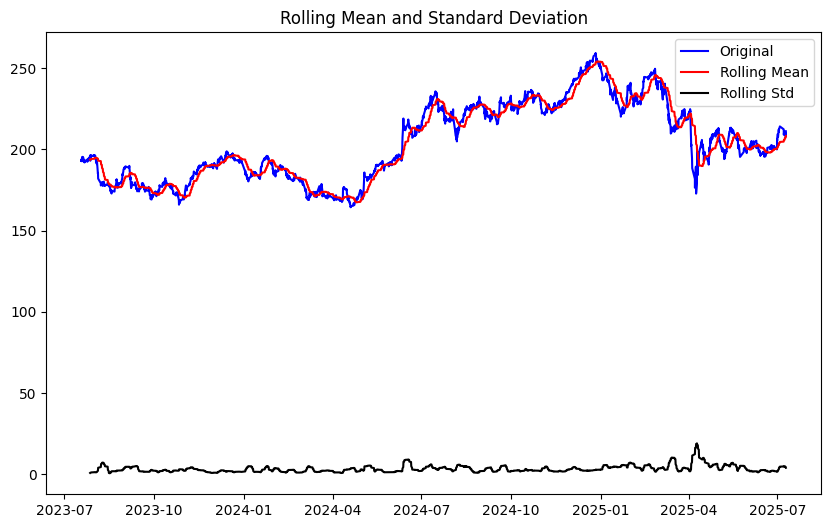

In [93]:
def test_stationarity(timeseries):
   
    rolmean = timeseries.rolling(50).mean()
    rolstd = timeseries.rolling(50).std()
 
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    print("Results of dickey fuller test")
    adft = adfuller(timeseries)
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(msft_df['Close'])

Interpretation: 
* Null Hypothesis: The time series is non-stationary.
* Alternative Hypothesis: The time series is stationary.

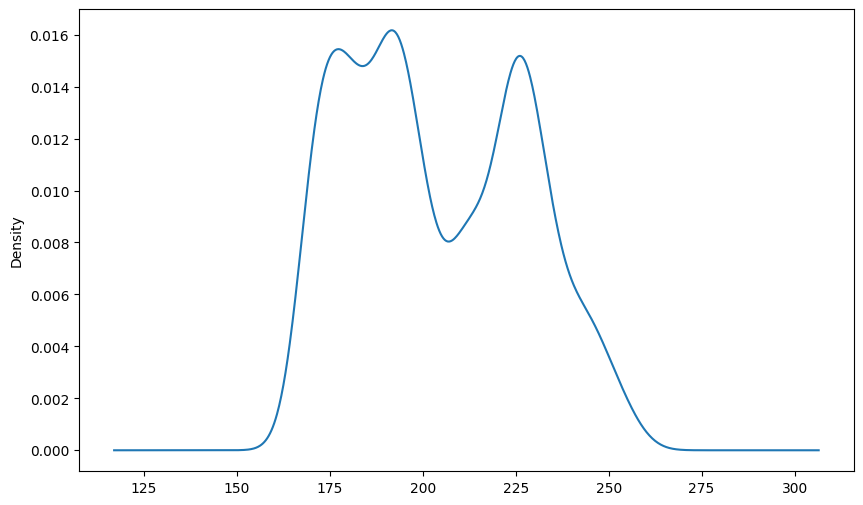

In [94]:
msft_df['Close'].plot(kind='kde');

In [95]:
# result = seasonal_decompose(msft_df['Close'], model='multiplicative', period = 78)
# fig = plt.figure()  
# fig = result.plot()  
# fig.set_size_inches(16, 9);

## Reducing Trend Plot

C:\Users\billy\AppData\Local\Temp\ipykernel_30332\4062080194.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


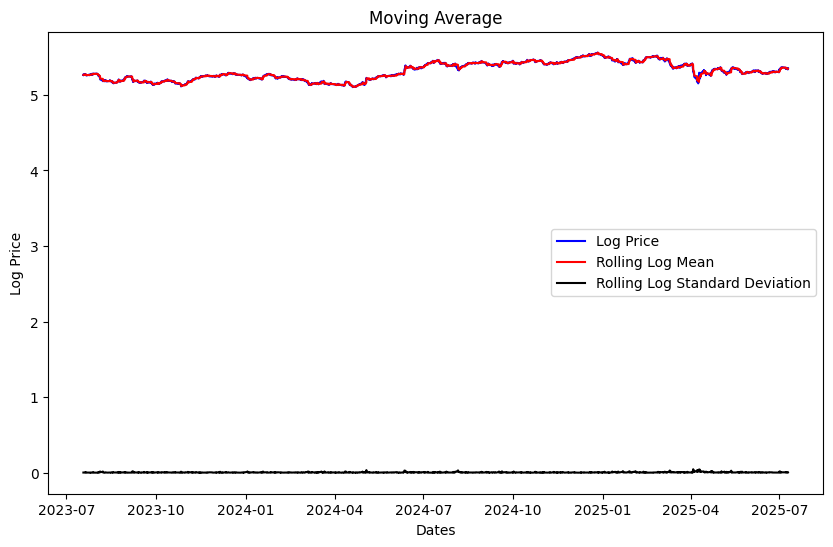

In [96]:
rcParams['figure.figsize'] = 10, 6
# msft_df['Log_Close'] = np.log(msft_df['Close'])
# msft_df['Rolling_Log_Avg'] = msft_df['Log_Close'].rolling(7).mean()
# msft_df['Rolling_Log_Std'] = msft_df['Log_Close'].rolling(7).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(msft_df['Log_Close'], color='blue', label = 'Log Price')
plt.plot(msft_df['Rolling_Log_Avg'], color="red", label = "Rolling Log Mean")
plt.plot(msft_df['Rolling_Log_Std'], color = "black", label = "Rolling Log Standard Deviation")
plt.xlabel('Dates')
plt.ylabel('Log Price')
plt.legend()
plt.show()

## Train/Test Plot

In [97]:
# msft_df.dropna(inplace=True)
# train_size = int(len(msft_df) * 0.99)
# train_data, test_data =  msft_df['Rolling_Log_Avg'].iloc[:train_size], msft_df['Rolling_Log_Avg'].iloc[train_size:]
# plt.figure(figsize=(10,6))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('Rolling Log Closing Prices')
# plt.plot(train_data, 'green', label='Train data')
# plt.plot(test_data, 'blue', label='Test data')
# plt.legend();

# HyperParameter Tuning (ARIMAX): P, D, Q

In [98]:
X = msft_df.drop(['Close'], axis=1)
y = msft_df['Close']

In [99]:
arimax_hypertuned = auto_arima(
                    y,
                    exogenous=X,
                    seasonal=False,
                    start_p=0, 
                    start_q=0,
                    test='adf',
                    max_p=5, max_q=5, 
                    m=7,              
                    d=None, 
                    D=None, 
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=False)

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarn

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11765.425, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11767.300, Time=0.16 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11767.007, Time=0.28 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11768.669, Time=0.48 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=11770.430, Time=0.74 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=11771.851, Time=1.10 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11767.306, Time=0.37 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11758.945, Time=0.78 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11759.594, Time=1.24 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11761.594, Time=2.01 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=11762.733, Time=1.73 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11767.054, Time=0.32 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11759.593, Time=1.27 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11761.593, Time=2.73 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11762.822, Time=4.70 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11768.776, Time=0.47 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11770.775, Time=0.45 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11762.861, Time=4.67 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=11770.692, Time=0.52 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11772.691, Time=0.79 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=11772.372, Time=0.86 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 25.740 seconds


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3452
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5875.472
Date:                Wed, 09 Jul 2025   AIC                          11758.945
Time:                        22:16:21   BIC                          11783.530
Sample:                             0   HQIC                         11767.725
                               - 3452                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0099      0.044      0.225      0.822      -0.076       0.096
ar.L1         -0.8848      0.048    -18.416      0.000      -0.979      -0.791
ma.L1          0.9105      0.042     21.657      0.0

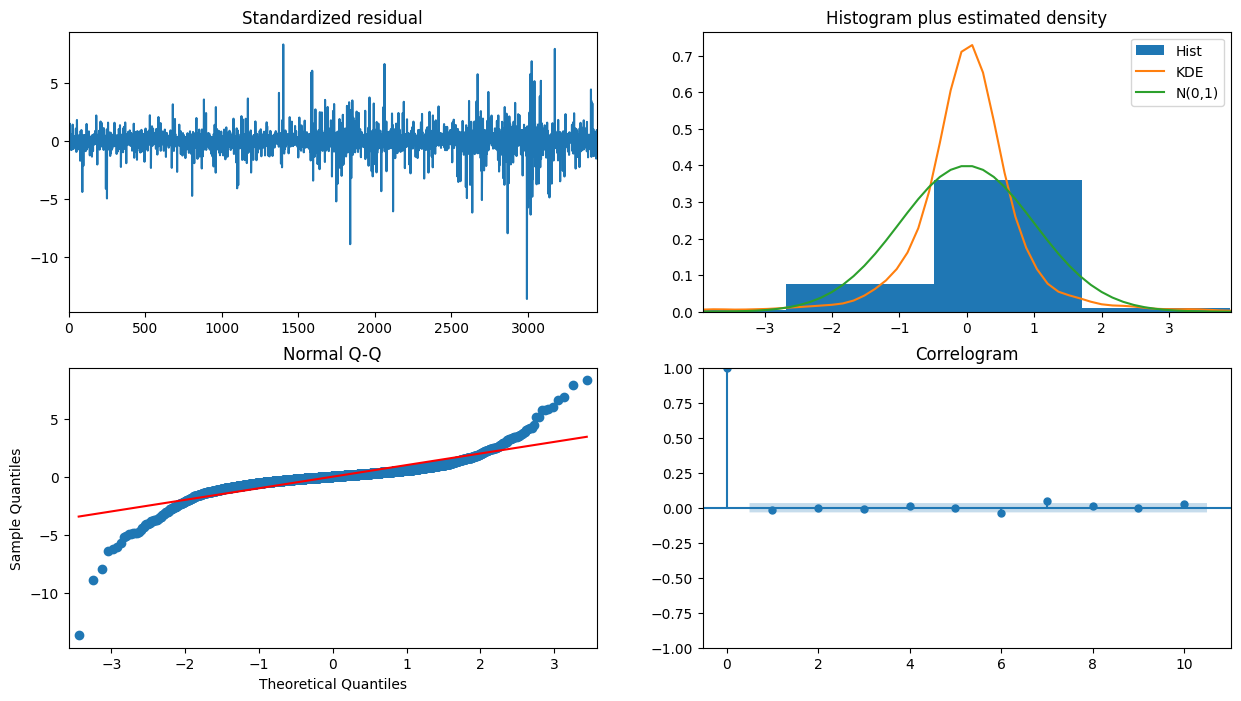

In [100]:
print(arimax_hypertuned.summary())

arimax_hypertuned.plot_diagnostics(figsize=(15,8))
plt.show()

In [101]:
arima_hypertuned = auto_arima(
                    y,
                    seasonal=False,
                    start_p=0, 
                    start_q=0,
                    test='adf',
                    max_p=5, max_q=5, 
                    m=7,              
                    d=None, 
                    D=None, 
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=False)

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarn

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11765.425, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11767.300, Time=0.21 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11767.007, Time=0.34 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11768.669, Time=0.55 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=11770.430, Time=0.83 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=11771.851, Time=0.97 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11767.306, Time=0.32 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11758.945, Time=1.29 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11759.594, Time=1.14 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11761.594, Time=2.88 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=11762.733, Time=2.20 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11767.054, Time=0.32 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11759.593, Time=1.53 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11761.593, Time=2.40 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11762.822, Time=4.06 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11768.776, Time=0.25 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11770.775, Time=0.54 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11762.861, Time=3.94 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=11770.692, Time=0.49 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11772.691, Time=0.65 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=11772.372, Time=0.90 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 25.943 seconds


In [102]:
print(arima_hypertuned.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3452
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5875.472
Date:                Wed, 09 Jul 2025   AIC                          11758.945
Time:                        22:16:47   BIC                          11783.530
Sample:                             0   HQIC                         11767.725
                               - 3452                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0099      0.044      0.225      0.822      -0.076       0.096
ar.L1         -0.8848      0.048    -18.416      0.000      -0.979      -0.791
ma.L1          0.9105      0.042     21.657      0.0

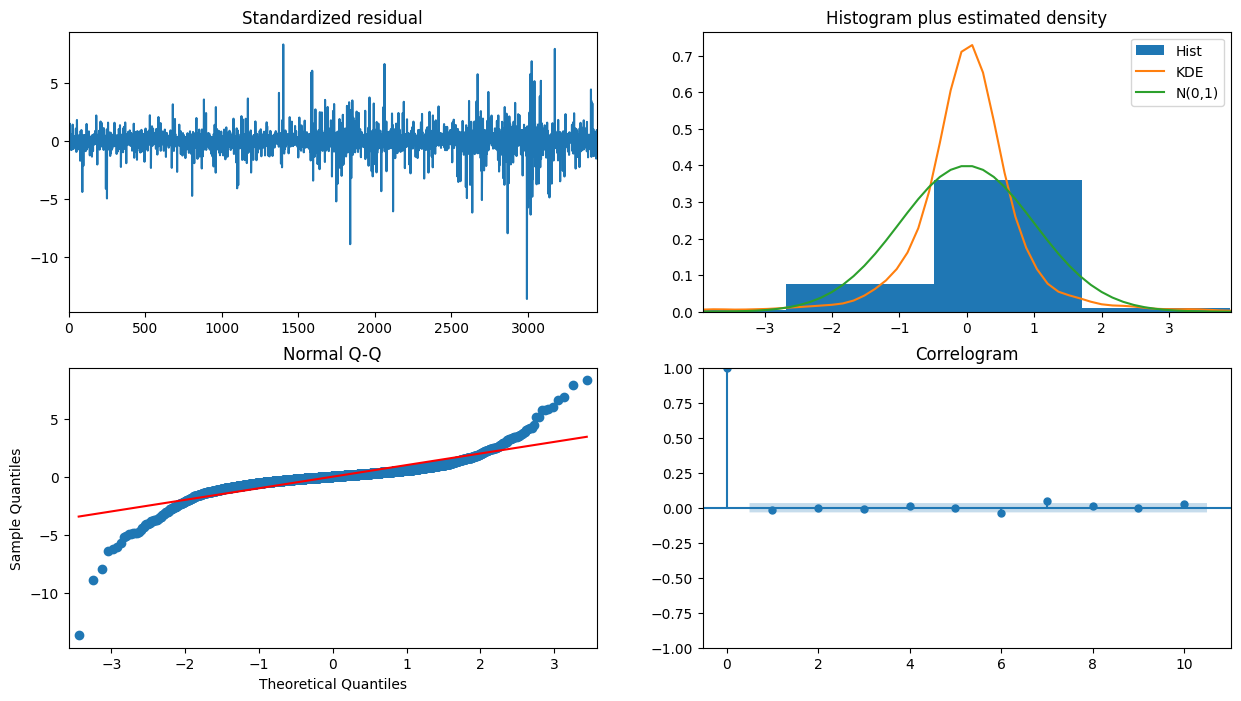

In [103]:
arima_hypertuned.plot_diagnostics(figsize=(15,8))
plt.show()

## Test residual autocorrelation

In [104]:
# residuals = model_autoARIMA.resid()
# plt.figure(figsize=(10,5))
# plt.plot(residuals, label="Residuals")
# plt.legend()
# plt.title("Residuals Over Time")
# plt.show()

Ljung-Box Test Hypothesis test
* Null Hypothesis: - The residuals are independently distributed (i.e., no autocorrelation).
* Alternative: The residuals are not independent (i.e., they're autocorrelated)

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(residuals, lags=[1], return_df=True)
print(ljung_box_results)

NameError: name 'residuals' is not defined

# ARIMAX Model

In [106]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
tscv = TimeSeriesSplit(n_splits=10)
best_p, best_d, bestq = arimax_hypertuned.order

actual_values = []
predicted_values = []

X_floats = X.select_dtypes(np.number).astype(float) # to convert bools to 1.0 or 0.

for i, (train_idx, test_idx) in enumerate(tscv.split(msft_df)):
    print("fold:", i)
    print("Train dates:", msft_df.index[train_idx][[0, -1]])
    print("Test dates:", msft_df.index[test_idx][[0, -1]])
    print("Full y_test dates:", msft_df.index[test_idx][[0, -1]])
    X_train, X_test = X_floats.iloc[train_idx], X_floats.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    arimax = SARIMAX(endog=y_train, exog=X_train, order =(best_p, best_d, bestq), seasonal_order=(0,0,0,0))
    arimax_fit = arimax.fit()
    forecast = arimax_fit.forecast(steps=1, exog=X_test.iloc[[0]])
    actual_values.append(y_test.iloc[0])
    predicted_values.append(forecast.values[0])
    print(f"  Actual value: {y_test.iloc[0]:.8f}") 
    print(f"  Predicted level: {forecast.values[0]}")

print("Actual Vs Predicted:", mean_squared_error(actual_values, predicted_values))


fold: 0
Train dates: DatetimeIndex(['2023-07-18 09:30:00-04:00', '2023-09-20 15:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
Test dates: DatetimeIndex(['2023-09-21 09:30:00-04:00', '2023-11-22 13:30:00-05:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
y_train start: 2023-07-18 09:30:00-04:00 192.98500061
y_train end: 2025-02-27 15:30:00-05:00 237.38000488
y_train length: 2826
Full y_test dates: DatetimeIndex(['2023-09-21 09:30:00-04:00', '2023-11-22 13:30:00-05:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer

  Actual value: 175.39520264
  Predicted level: 175.39520260795445
fold: 1
Train dates: DatetimeIndex(['2023-07-18 09:30:00-04:00', '2023-11-22 13:30:00-05:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
Test dates: DatetimeIndex(['2023-11-22 14:30:00-05:00', '2024-01-30 15:30:00-05:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
y_train start: 2023-07-18 09:30:00-04:00 192.98500061
y_train end: 2023-09-20 15:30:00-04:00 175.49000549
y_train length: 322
Full y_test dates: DatetimeIndex(['2023-11-22 14:30:00-05:00', '2024-01-30 15:30:00-05:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

  Actual value: 191.51249695
  Predicted level: 191.51249693127187
fold: 2
Train dates: DatetimeIndex(['2023-07-18 09:30:00-04:00', '2024-01-30 15:30:00-05:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
Test dates: DatetimeIndex(['2024-01-31 09:30:00-05:00', '2024-04-04 13:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
y_train start: 2023-07-18 09:30:00-04:00 192.98500061
y_train end: 2023-11-22 13:30:00-05:00 191.63499451
y_train length: 635
Full y_test dates: DatetimeIndex(['2024-01-31 09:30:00-05:00', '2024-04-04 13:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer i

  Actual value: 185.01499939
  Predicted level: 185.01499942504717
fold: 3
Train dates: DatetimeIndex(['2023-07-18 09:30:00-04:00', '2024-04-04 13:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
Test dates: DatetimeIndex(['2024-04-04 14:30:00-04:00', '2024-06-07 11:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
y_train start: 2023-07-18 09:30:00-04:00 192.98500061
y_train end: 2024-01-30 15:30:00-05:00 187.97999573
y_train length: 948
Full y_test dates: DatetimeIndex(['2024-04-04 14:30:00-04:00', '2024-06-07 11:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

  Actual value: 169.04100037
  Predicted level: 169.04100037077563
fold: 4
Train dates: DatetimeIndex(['2023-07-18 09:30:00-04:00', '2024-06-07 11:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
Test dates: DatetimeIndex(['2024-06-07 12:30:00-04:00', '2024-08-13 13:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
y_train start: 2023-07-18 09:30:00-04:00 192.98500061
y_train end: 2024-04-04 13:30:00-04:00 169.75000000
y_train length: 1261
Full y_test dates: DatetimeIndex(['2024-06-07 12:30:00-04:00', '2024-08-13 13:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

  Actual value: 196.36000061
  Predicted level: 196.3600005918372
fold: 5
Train dates: DatetimeIndex(['2023-07-18 09:30:00-04:00', '2024-08-13 13:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
Test dates: DatetimeIndex(['2024-08-13 14:30:00-04:00', '2024-10-16 11:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
y_train start: 2023-07-18 09:30:00-04:00 192.98500061
y_train end: 2024-06-07 11:30:00-04:00 195.95500183
y_train length: 1574
Full y_test dates: DatetimeIndex(['2024-08-13 14:30:00-04:00', '2024-10-16 11:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

  Actual value: 220.66000366
  Predicted level: 220.66000367753628
fold: 6
Train dates: DatetimeIndex(['2023-07-18 09:30:00-04:00', '2024-10-16 11:30:00-04:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
Test dates: DatetimeIndex(['2024-10-16 12:30:00-04:00', '2024-12-19 13:30:00-05:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
y_train start: 2023-07-18 09:30:00-04:00 192.98500061
y_train end: 2024-08-13 13:30:00-04:00 221.21800232
y_train length: 1887
Full y_test dates: DatetimeIndex(['2024-10-16 12:30:00-04:00', '2024-12-19 13:30:00-05:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)


KeyboardInterrupt: 

### ArimaX Results

In [108]:
results_df = pd.DataFrame({
    "Actual_vs_Predicted": [mean_squared_error(actual_values, predicted_values)]
})
results_df

,Actual_vs_Predicted
0,0.000316


In [111]:
np.corrcoef(actual_values, predicted_values)

array([[1.        , 0.99999973],
       [0.99999973, 1.        ]])

# ARIMA Model

In [133]:
tscv = TimeSeriesSplit(n_splits=100)
best_p, best_d, bestq = arima_hypertuned.order

actual_values2 = []
predicted_values2 = []


for i, (train_idx, test_idx) in enumerate(tscv.split(msft_df)):
    # print("fold:", i)
    # print("Train dates:", msft_df.index[train_idx][[0, -1]])
    # print("Test dates:", msft_df.index[test_idx][[0, -1]])
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    arima = ARIMA(y_train, order =(best_p, best_d, bestq))
    arima_fit = arima.fit()
    forecast = arima_fit.forecast(steps=1)
    actual_values2.append(y_test.iloc[0])
    predicted_values2.append(forecast.values[0])

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results w

### Arima Results

In [135]:
results_df = pd.DataFrame({
    "Actual_vs_Predicted": [mean_squared_error(actual_values2, predicted_values2)]
})
results_df

,Actual_vs_Predicted
0,8.671540e-07


In [17]:
# plt.figure(figsize=(14,7))
# plt.plot(train_data.index, train_data,  label='training data')
# plt.plot(test_data.index, test_data, color = 'blue', label='Actual Stock Price')
# plt.plot(test_data.index, forecast, color = 'orange',label='Predicted Stock Price')
# plt.title('Microsoft Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('MSFT Stock Price')
# plt.legend(loc='upper left', fontsize=8)
# #plt.savefig("3mo.png", dpi=300, bbox_inches="tight")
# plt.show()

In [18]:
# forecast = arima_fitted.forecast(steps=len(test_data))
# plt.figure(figsize=(20,10))
# plt.plot(train_data.index, train_data,  label='training data')
# plt.plot(test_data.index, test_data, color = 'blue', label='Actual Stock Price')
# plt.plot(test_data.index, forecast, color = 'orange',label='Predicted Stock Price')
# plt.title('Microsoft Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('MSFT Stock Price')
# plt.legend(loc='upper left', fontsize=8)
# #plt.savefig("3mo.png", dpi=300, bbox_inches="tight")
# plt.show()

In [19]:
# print("Mean Squared Error:", mean_squared_error(test_data, forecast))
# print("Root Mean Square Error:", np.sqrt(mean_squared_error(test_data, forecast)))
# print("Mean Absolute Error:", mean_absolute_error(test_data, forecast))
# print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(test_data, forecast))

In [20]:
# timestamps = test_data.index[-4:]  
# actual_values = np.exp(test_data.iloc[-4:])
# predicted_values = np.exp(forecast[-4:])

# df_results = pd.DataFrame({
#     'Timestamp': timestamps,
#     'Actual Value': actual_values.values, 
#     'Predicted Value': predicted_values
# })

# print(df_results)

In [21]:
# msft_df['price_lag_1hour'] = msft_df['Close'].shift(1)
# msft_df['price_lag_2hour'] = msft_df['Close'].shift(2)
# msft_df['price_lag_3hour'] = msft_df['Close'].shift(3)
# msft_df['price_lag_4hour'] = msft_df['Close'].shift(4)
# msft_df['price_lag_1day'] = msft_df['Close'].shift(24)
# msft_df['price_lag_2day'] = msft_df['Close'].shift(48)
# msft_df['price_lag_2day'] = msft_df['Close'].shift(72)
# msft_df['price_lag_1week'] = msft_df['Close'].shift(168)